In [1]:
%matplotlib inline

In [2]:
import os
import sys
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json
import math
from matplotlib import pyplot as plt 
import torch.autograd as autograd
import random

from pathlib import Path
import collections.abc as container_abcs

from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma

sys.path.append('../')
from datasets import build_dataset, build_transform
from utils import DistillationLoss, RASampler, unnormalize_image
import models.vit
import models.absvit
import utils
from config import config
from typing import Iterable, Optional
from einops import rearrange

import warnings
warnings.filterwarnings("ignore")

## Args

In [3]:
parser = argparse.ArgumentParser('DeiT training and evaluation script')
args = parser.parse_args(args=[])
args.attention = 'self-att'
args.model = 'absvit_tiny_patch8_224_gap'
args.resume = 'https://berkeley.box.com/shared/static/7415yz4d1l5z0ur6x32k35f8y99zgynq.pth'

## Loading Pretrained AbSViT

In [4]:
print('Not using distributed mode')
args.distributed = False

device = torch.device("cuda")

cudnn.benchmark = True

print(f"Creating model: {args.model}")
model = create_model(
    args.model,
    pretrained=False,
    num_classes=1000,
    drop_rate=0,
    drop_path_rate=0.1,
    drop_block_rate=None
)
model.to('cuda:0')

model_without_ddp = model
checkpoint = torch.utils.model_zoo.load_url(args.resume)
model_without_ddp.load_state_dict(checkpoint['model'])

Not using distributed mode
Creating model: absvit_tiny_patch8_224_gap


Downloading: "https://berkeley.box.com/shared/static/7415yz4d1l5z0ur6x32k35f8y99zgynq.pth" to /home/bfshi/.cache/torch/hub/checkpoints/7415yz4d1l5z0ur6x32k35f8y99zgynq.pth


  0%|          | 0.00/101M [00:00<?, ?B/s]

<All keys matched successfully>

## Loading a Regular ViT as Baseline

In [5]:
print(f"Creating model: {args.model}")
args.model = 'vit_tiny_patch8_224_gap'
args.resume = 'https://berkeley.box.com/shared/static/zzy0bl6b59q05a3hobbehqeuhg5u1mhk.pth'
model_ff = create_model(
    args.model,
    pretrained=False,
    num_classes=1000,
    drop_rate=0,
    drop_path_rate=0.1,
    drop_block_rate=None
)
model_ff.to('cuda:0')

model_ff_without_ddp = model_ff
checkpoint = torch.utils.model_zoo.load_url(args.resume)
model_ff_without_ddp.load_state_dict(checkpoint['model'])

Creating model: absvit_tiny_patch8_224_gap


Downloading: "https://berkeley.box.com/shared/static/zzy0bl6b59q05a3hobbehqeuhg5u1mhk.pth" to /home/bfshi/.cache/torch/hub/checkpoints/zzy0bl6b59q05a3hobbehqeuhg5u1mhk.pth


  0%|          | 0.00/87.5M [00:00<?, ?B/s]

<All keys matched successfully>

In [6]:
_ = model.eval()
_ = model_ff.eval()

## Helper Functions

In [7]:
def get_attention(self, x, td=None):
    layer = len(self.blocks)-3
    x = self.patch_embed(x)
    x = self._pos_embed(x)
    for i in range(layer):
        if td is None:
            x = self.blocks[i](x)
        else:
            x = self.blocks[i](x, td[i])
    attn = x.norm(dim=-1)[:, self.num_prefix_tokens:]
    return attn

def load_image(path):
    img = plt.imread(path)
    img = torch.Tensor(img).float().cuda().permute(2, 0, 1)
    img = img / 255
    mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().view(3, 1, 1)
    std = torch.Tensor([0.229, 0.224, 0.225]).cuda().view(3, 1, 1)
    img = (img - mean) / std
    img = F.interpolate(img[None], size=224, mode='bicubic')[0]
    return img

## Comparing Attention of Single-Object Image between ViT and AbSViT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


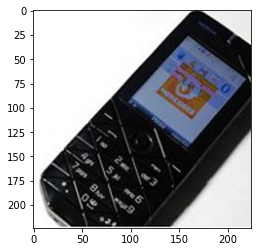

In [8]:
# x0 = load_image('single_object_image_1.jpg')
x0 = load_image('single_object_image_2.jpg')
img = unnormalize_image(x0)
plt.imshow(img)
plt.show()

feedforward attention map:


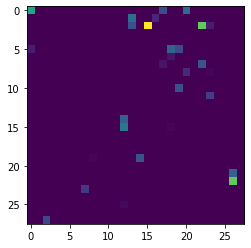

In [9]:
print("feedforward attention map:")
x = x0[None, ...]
att = get_attention(model_ff, x)
L = att.shape[-1]
att = att[0].view(int(L**0.5), int(L**0.5))
att = (att - (0.7*att.max() + 0.3*att.min())).clamp(0)
plt.imshow(att.detach().cpu().numpy())
plt.show()

prior mask:


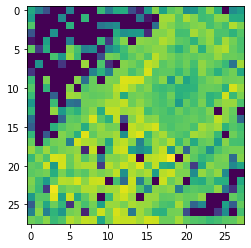

feedback attention with prompt:


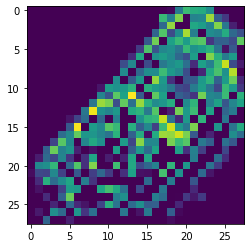

In [10]:
print("prior mask:")
input = x0[None, ...]
x, _, __ = model.forward_features(input)
cos_sim = F.normalize(x, dim=-1) @ F.normalize(model.prompt[None, ..., None], dim=1)  # B, N, 1
mask = cos_sim.clamp(0, 1)
mask_vis = mask[0, model.num_prefix_tokens:].squeeze().view(int(L**0.5), int(L**0.5))
mask_vis = (mask_vis - (0.7*mask_vis.max() + 0.3*mask_vis.min())).clamp(0)
plt.imshow(mask_vis.detach().cpu().numpy())
plt.show()


print("feedback attention with prompt:")
x = x * mask
td = model.feedback(x)
att = get_attention(model, input, td)
L = att.shape[-1]
att = att[0].view(int(L**0.5), int(L**0.5))
att = (att - (0.7*att.max() + 0.3*att.min())).clamp(0)
plt.imshow(att.detach().cpu().numpy())
plt.show()

## Controllable Top-down Attention

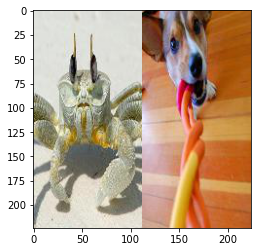

In [11]:
y0 = 120
y1 = 264
x_bi = load_image('multi_object_artificial_120_264.jpg')

# y0 = 282
# y1 = 291
# x_bi = load_image('multi_object_artificial_282_291.jpg')

# y0 = 879 # umbrella
# y1 = 200 # dog
# x_bi = load_image('multi_object_real_879_200.jpg')


x_bi = x_bi[None]
img = unnormalize_image(x_bi)
plt.imshow(img)
plt.show()


Bottom-up attention:


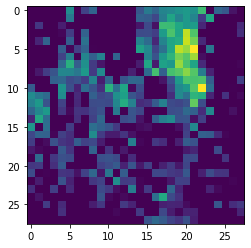

In [12]:
input = x_bi
x, _, __ = model.forward_features(input)
cos_sim = F.normalize(x, dim=-1) @ F.normalize(model.prompt[None, ..., None], dim=1)  # B, N, 1
mask = cos_sim.clamp(0, 1)
x = x * mask
td = model.feedback(x)


att = get_attention(model, input, td)

print("Bottom-up attention:")
L = att.shape[-1]
att = att[0].view(int(L**0.5), int(L**0.5))
att = (att - (0.7*att.max() + 0.3*att.min())).clamp(0)
plt.imshow(att.detach().cpu().numpy())
plt.show()

prior mask of class 1:


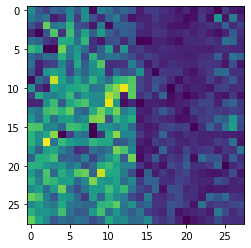

top-down attention of class 1:


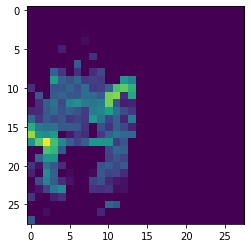

In [13]:
input = x_bi

x, _, __ = model.forward_features(input)
cos_sim = F.normalize(x, dim=-1) @ F.normalize(model.head.weight[y0][None, ..., None], dim=1)  # B, N, 1
mask = cos_sim.clamp(0, 1)*40
print("prior mask of class 1:")
plt.imshow(mask[0, 1:, 0].view(28, 28).detach().cpu().numpy())
plt.show()

x = x * mask
td = model.feedback(x)

att = get_attention(model, input, td)

print("top-down attention of class 1:")
L = att.shape[-1]
att = att[0].view(int(L**0.5), int(L**0.5))
att = (att - (0.7*att.max() + 0.3*att.min())).clamp(0)
plt.imshow(att.detach().cpu().numpy())
plt.show()

prior mask of class 2:


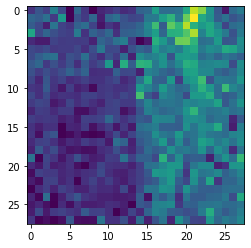

top-down attention of class 2


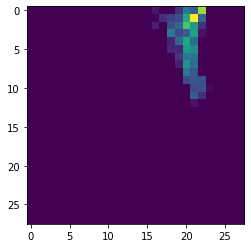

In [14]:
input = x_bi

x, _, __ = model.forward_features(input)
cos_sim = F.normalize(x, dim=-1) @ F.normalize(model.head.weight[y1][None, ..., None], dim=1)  # B, N, 1
mask = cos_sim.clamp(0, 1)*40
print("prior mask of class 2:")
plt.imshow(mask[0, 1:, 0].view(28, 28).detach().cpu().numpy())
plt.show()

x = x * mask
td = model.feedback(x)

att = get_attention(model, input, td)

print("top-down attention of class 2")
L = att.shape[-1]
att = att[0].view(int(L**0.5), int(L**0.5))
att = (att - (0.7*att.max() + 0.3*att.min())).clamp(0)
plt.imshow(att.detach().cpu().numpy())
plt.show()

### 